# ME5413 Homework 3: Planning

## Task 0: Load the Map

In [7]:
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt
%matplotlib inline

Size of the map: (1000, 1000)
Occupied Cells: 823039
Free Cells: 176961


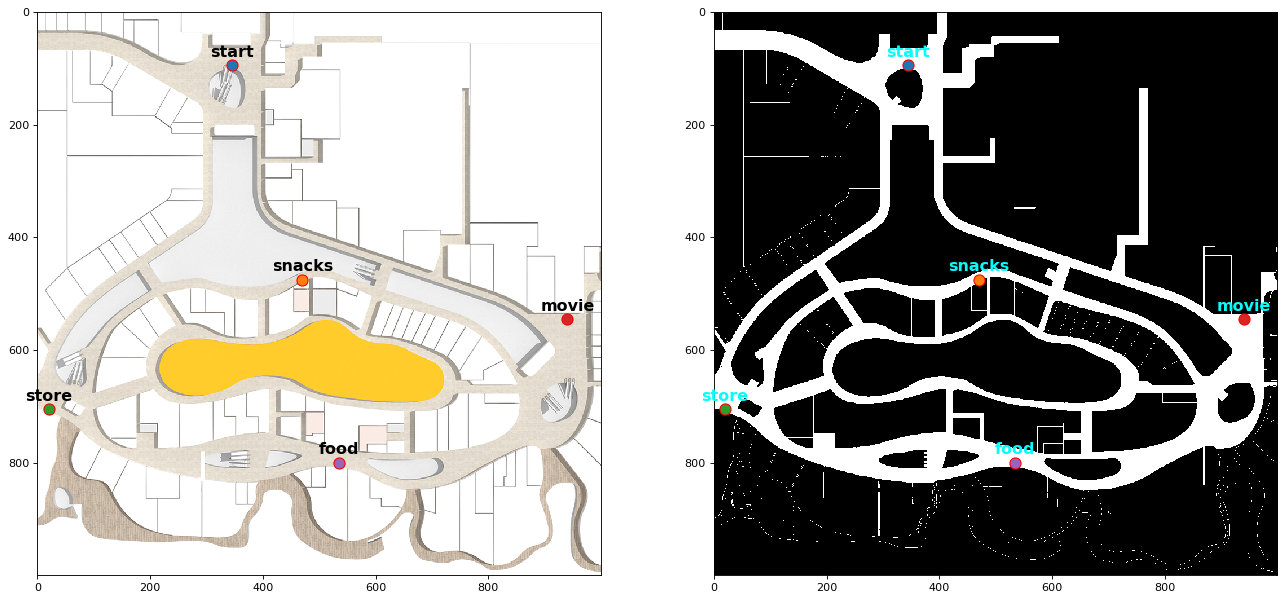

Cell start is free: True
Cell snacks is free: True
Cell store is free: True
Cell movie is free: True
Cell food is free: True


In [9]:
# Load the map
floor_plan = imageio.imread('./map/vivocity.png')
grid_map_img = imageio.imread('./map/vivocity_freespace.png')
grid_map = grid_map_img.transpose()
print("Size of the map:", grid_map.shape)
print("Occupied Cells:", np.count_nonzero(grid_map == 0))
print("Free Cells:", np.count_nonzero(grid_map == 255))

# Map resolution (Constant)
MAP_RES = 0.2 # each cell represents a 0.2m x 0.2m square in reality

# Locations on the map
locations = {'start':  [345, 95],    # Start from the level 2 Escalator
             'snacks': [470, 475],   # Garrett Popcorn
             'store':  [20, 705],    # DJI Store
             'movie':  [940, 545],   # Golden Village
             'food':   [535, 800],   # PUTIEN
            }

# A helper function to mark the locations on the map
def plot_locations(locations: dict, color: 'str'='black'):
    for key, value in locations.items():
        plt.plot(locations[key][0], locations[key][1], marker="o", markersize=10, markeredgecolor="red")
        plt.text(locations[key][0], locations[key][1]-15, s=key, fontsize='x-large', fontweight='bold', c=color, ha='center')
    return

# Plot the locaitons on the map 
plt.figure(figsize=(20, 10), dpi=80)
plt.subplot(1,2,1)
plt.imshow(floor_plan)
plot_locations(locations)
plt.subplot(1,2,2)
plt.imshow(grid_map_img, cmap='gray')
plot_locations(locations, color='cyan')
plt.show()

# Check if the designated locations are free
for key, value in locations.items():
    print(f"Cell {key} is free: {grid_map[value[0], value[1]] == 255}")

## Task 1

===== Waypoint Accessibility Verification =====
Passed: start (y=95, x=345) is accessible
Passed: snacks (y=475, x=460) is accessible
Passed: store (y=705, x=20) is accessible
Passed: food (y=800, x=535) is accessible
Passed: movie (y=545, x=940) is accessible

Segment 1 (start → snacks):
Path points: 648
Distance: 144.00 meters

Segment 2 (snacks → store):
Path points: 492
Distance: 112.88 meters

Segment 3 (store → food):
Path points: 516
Distance: 110.79 meters

Segment 4 (food → movie):
Path points: 501
Distance: 113.12 meters

Total Travel Distance: 480.78 meters


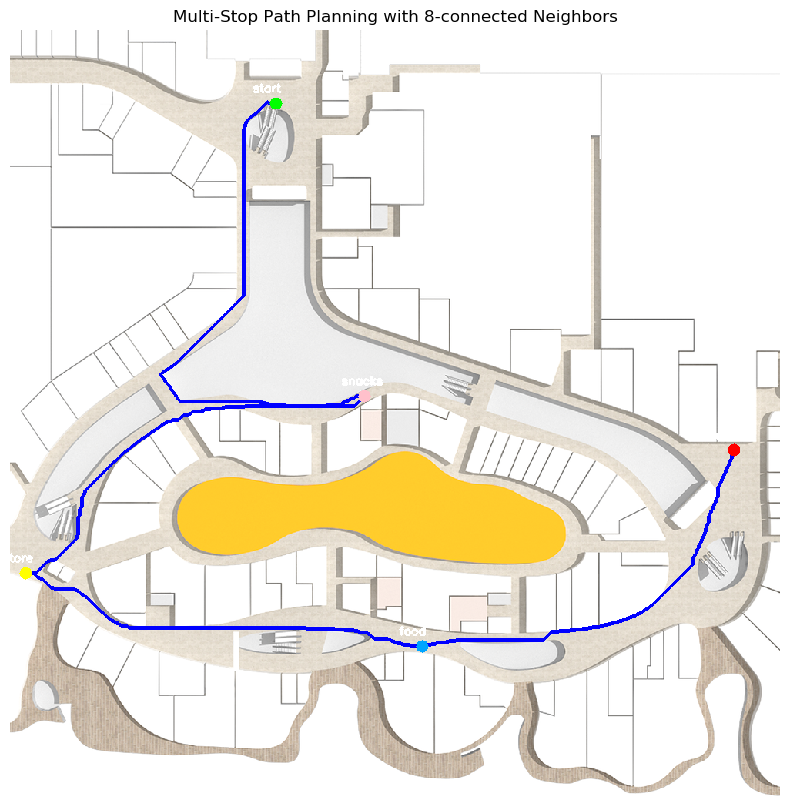

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from queue import PriorityQueue
import math

# Map processing
map_img = cv2.imread('./map/vivocity.png')
map_img = cv2.cvtColor(map_img, cv2.COLOR_BGR2RGB)
light_free = (210, 200, 190)
dark_free = (250, 240, 230)
free_space = cv2.inRange(map_img, light_free, dark_free)

# Movement costs
MOVE_COST_STRAIGHT = 0.2    # Straight movement cost (meters)
MOVE_COST_DIAGONAL = 0.282  # Diagonal movement cost (meters)

class Node:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.g = float('inf')  # Actual movement cost
        self.h = 0             # Heuristic estimate
        self.parent = None

    def __lt__(self, other):
        return (self.g + self.h) < (other.g + other.h)

def heuristic(a, b, method='octile'):
    dx = abs(a.x - b.x)
    dy = abs(a.y - b.y)
    if method == 'euclidean':
        return math.sqrt(dx**2 + dy**2) * MOVE_COST_STRAIGHT
    elif method == 'manhattan':
        return (dx + dy) * MOVE_COST_STRAIGHT
    elif method == 'octile':
        # Octile distance (optimized for 8-direction movement)
        return MOVE_COST_STRAIGHT * (dx + dy) + (MOVE_COST_DIAGONAL - 2 * MOVE_COST_STRAIGHT) * min(dx, dy)
    else:
        raise ValueError("Unknown heuristic method")

def a_star(start, goal, grid, heuristic_method='octile', h_weight=1.0):
    rows, cols = grid.shape
    open_set = PriorityQueue()
    
    start_node = Node(*start)
    goal_node = Node(*goal)
    
    start_node.g = 0
    start_node.h = h_weight * heuristic(start_node, goal_node, heuristic_method)
    open_set.put((start_node.g + start_node.h, start_node))
    
    # Track node costs with dictionary for potential revisits
    node_map = {}
    node_map[(start_node.x, start_node.y)] = start_node
    
    while not open_set.empty():
        _, current = open_set.get()
        
        if current.x == goal_node.x and current.y == goal_node.y:
            # Reconstruct path and calculate total distance
            path = []
            total_distance = 0.0
            while current.parent:
                dx = abs(current.x - current.parent.x)
                dy = abs(current.y - current.parent.y)
                if dx == 1 and dy == 1:
                    total_distance += MOVE_COST_DIAGONAL
                else:
                    total_distance += MOVE_COST_STRAIGHT
                path.append((current.x, current.y))
                current = current.parent
            path.append((current.x, current.y))
            return path[::-1], total_distance
        
        # 8-direction search
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                if dx == 0 and dy == 0:
                    continue
                
                x = current.x + dx
                y = current.y + dy
                
                if 0 <= x < rows and 0 <= y < cols:
                    if grid[x, y] == 255:  # Check walkable area
                        move_cost = MOVE_COST_DIAGONAL if (dx != 0 and dy != 0) else MOVE_COST_STRAIGHT
                        tentative_g = current.g + move_cost
                        
                        # Update node if new path is better
                        if (x, y) not in node_map or tentative_g < node_map[(x, y)].g:
                            neighbor = Node(x, y)
                            neighbor.g = tentative_g
                            neighbor.h = h_weight * heuristic(neighbor, goal_node, heuristic_method)
                            neighbor.parent = current
                            node_map[(x, y)] = neighbor
                            open_set.put((neighbor.g + neighbor.h, neighbor))
    
    return None, 0.0  # No path found

# ======================================================================
# Waypoint definitions (pre-verified coordinates)
# Format: (y, x) matching matrix coordinates
locations = {
    'start':  (95, 345),    # Original map coordinates (x=345, y=95)
    'snacks': (475, 460),   # Snack shop
    'store':  (705, 20),    # Retail store
    'food':   (800, 535),   # Restaurant
    'movie':  (545, 940),   # Cinema
}

# Verify waypoint accessibility
print("===== Waypoint Accessibility Verification =====")
valid = True
for name, (y, x) in locations.items():
    if free_space[y, x] != 255:
        print(f"Error: {name} in obstacle area (y={y}, x={x})")
        valid = False
    else:
        print(f"Passed: {name} (y={y}, x={x}) is accessible")
if not valid:
    raise ValueError("Please adjust waypoint coordinates!")

# ======================================================================
# Multi-stop path planning
waypoints_order = ['start', 'snacks', 'store', 'food', 'movie']
waypoints = [locations[name] for name in waypoints_order]

full_path = []
total_distance = 0.0
for i in range(len(waypoints) - 1):
    start = waypoints[i]
    goal = waypoints[i + 1]
    path_segment, segment_distance = a_star(start, goal, free_space, 
                                           heuristic_method='octile', 
                                           h_weight=1.0)
    
    if path_segment:
        full_path.extend(path_segment)
        total_distance += segment_distance
        print(f"\nSegment {i+1} ({waypoints_order[i]} → {waypoints_order[i+1]}):")
        print(f"Path points: {len(path_segment)}")
        print(f"Distance: {segment_distance:.2f} meters")
    else:
        print(f"\nError: No path between {waypoints_order[i]} and {waypoints_order[i+1]}!")
        break

print("\n=======================================")
print(f"Total Travel Distance: {total_distance:.2f} meters")
print("=======================================")

# ======================================================================
# Visualization
result_img = map_img.copy()

# Draw complete path
if full_path:
    for (y, x) in full_path:
        cv2.circle(result_img, (x, y), 2, (0, 0, 255), -1)  # Red path
    
    # Mark waypoints
    colors = {'start': (0, 255, 0), 'snacks': (255, 192, 203), 
             'store': (255, 255, 0), 'food': (0, 165, 255), 
             'movie': (255, 0, 0)}
    for name, (y, x) in locations.items():
        cv2.circle(result_img, (x, y), 8, colors[name], -1)
        cv2.putText(result_img, name, (x-30, y-15), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 2)

plt.figure(figsize=(15, 10))
plt.imshow(result_img)
plt.title("Multi-Stop Path Planning with 8-connected Neighbors")
plt.axis('off')
plt.show()


## Task 2

===== Waypoint Accessibility Verification =====
Passed: start (y=95, x=345) is accessible
Passed: snacks (y=475, x=460) is accessible
Passed: store (y=705, x=20) is accessible
Passed: food (y=800, x=535) is accessible
Passed: movie (y=545, x=940) is accessible

Precomputing distance and path matrices...
Computed distances from start
Computed distances from snacks
Computed distances from store
Computed distances from food
Computed distances from movie

Brute-force optimal route: start → store → food → movie → snacks → start
Total distance: 630.85 meters

Nearest Neighbor route: start → snacks → movie → food → store → start
Total distance: 630.85 meters

===== Method Comparison =====
Brute-force optimal distance: 630.85 meters
Nearest Neighbor distance:    630.85 meters
Difference:                   0.00 meters


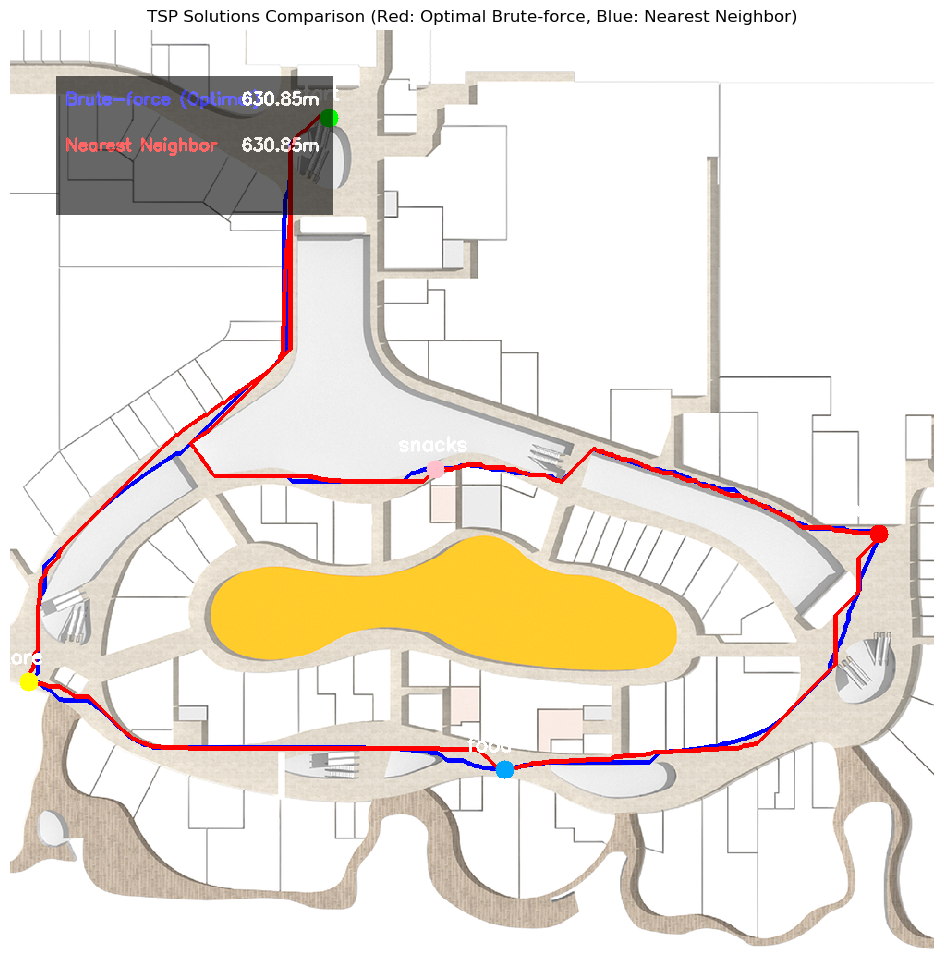

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from queue import PriorityQueue
import math
from itertools import permutations

# Map processing
map_img = cv2.imread('./map/vivocity.png')
map_img = cv2.cvtColor(map_img, cv2.COLOR_BGR2RGB)
light_free = (210, 200, 190)
dark_free = (250, 240, 230)
free_space = cv2.inRange(map_img, light_free, dark_free)

# Movement costs
MOVE_COST_STRAIGHT = 0.2    # Straight movement cost (meters)
MOVE_COST_DIAGONAL = 0.282  # Diagonal movement cost (meters)

class Node:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.g = float('inf')  # Actual movement cost
        self.h = 0             # Heuristic estimate
        self.parent = None

    def __lt__(self, other):
        return (self.g + self.h) < (other.g + other.h)

def heuristic(a, b, method='octile'):
    dx = abs(a.x - b.x)
    dy = abs(a.y - b.y)
    if method == 'euclidean':
        return math.sqrt(dx**2 + dy**2) * MOVE_COST_STRAIGHT
    elif method == 'manhattan':
        return (dx + dy) * MOVE_COST_STRAIGHT
    elif method == 'octile':
        return MOVE_COST_STRAIGHT * (dx + dy) + (MOVE_COST_DIAGONAL - 2 * MOVE_COST_STRAIGHT) * min(dx, dy)
    else:
        raise ValueError("Unknown heuristic method")

def a_star(start, goal, grid, heuristic_method='octile', h_weight=1.0):
    rows, cols = grid.shape
    open_set = PriorityQueue()
    
    start_node = Node(*start)
    goal_node = Node(*goal)
    
    start_node.g = 0
    start_node.h = h_weight * heuristic(start_node, goal_node, heuristic_method)
    open_set.put((start_node.g + start_node.h, start_node))
    
    node_map = {}
    node_map[(start_node.x, start_node.y)] = start_node
    
    while not open_set.empty():
        _, current = open_set.get()
        
        if current.x == goal_node.x and current.y == goal_node.y:
            path = []
            total_distance = 0.0
            while current.parent:
                dx = abs(current.x - current.parent.x)
                dy = abs(current.y - current.parent.y)
                if dx == 1 and dy == 1:
                    total_distance += MOVE_COST_DIAGONAL
                else:
                    total_distance += MOVE_COST_STRAIGHT
                path.append((current.x, current.y))
                current = current.parent
            path.append((current.x, current.y))
            return path[::-1], total_distance
        
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                if dx == 0 and dy == 0:
                    continue
                
                x = current.x + dx
                y = current.y + dy
                
                if 0 <= x < rows and 0 <= y < cols:
                    if grid[x, y] == 255:
                        move_cost = MOVE_COST_DIAGONAL if (dx != 0 and dy != 0) else MOVE_COST_STRAIGHT
                        tentative_g = current.g + move_cost
                        
                        if (x, y) not in node_map or tentative_g < node_map[(x, y)].g:
                            neighbor = Node(x, y)
                            neighbor.g = tentative_g
                            neighbor.h = h_weight * heuristic(neighbor, goal_node, heuristic_method)
                            neighbor.parent = current
                            node_map[(x, y)] = neighbor
                            open_set.put((neighbor.g + neighbor.h, neighbor))
    
    return None, 0.0

# Waypoint definitions
locations = {
    'start':  (95, 345),
    'snacks': (475, 460),
    'store':  (705, 20),
    'food':   (800, 535),
    'movie':  (545, 940),
}

# Verify waypoint accessibility
print("===== Waypoint Accessibility Verification =====")
valid = True
for name, (y, x) in locations.items():
    if free_space[y, x] != 255:
        print(f"Error: {name} in obstacle area (y={y}, x={x})")
        valid = False
    else:
        print(f"Passed: {name} (y={y}, x={x}) is accessible")
if not valid:
    raise ValueError("Adjust waypoint coordinates!")

# Precompute distance and path matrices
print("\nPrecomputing distance and path matrices...")
points = ['start', 'snacks', 'store', 'food', 'movie']
distance_matrix = {}
path_matrix = {}

for from_point in points:
    distance_matrix[from_point] = {}
    path_matrix[from_point] = {}
    for to_point in points:
        if from_point == to_point:
            distance_matrix[from_point][to_point] = 0.0
            path_matrix[from_point][to_point] = []
            continue
        start_coord = locations[from_point]
        goal_coord = locations[to_point]
        path_segment, segment_distance = a_star(start_coord, goal_coord, free_space)
        if path_segment is None:
            print(f"Warning: No path between {from_point} and {to_point}!")
            distance_matrix[from_point][to_point] = float('inf')
            path_matrix[from_point][to_point] = None
        else:
            distance_matrix[from_point][to_point] = segment_distance
            path_matrix[from_point][to_point] = path_segment
    print(f"Computed distances from {from_point}")

# Brute-force method
intermediate_points = ['snacks', 'store', 'food', 'movie']
all_perms = list(permutations(intermediate_points))

min_bf_distance = float('inf')
best_perm_bf = None

for perm in all_perms:
    total = distance_matrix['start'][perm[0]]
    for i in range(len(perm)-1):
        total += distance_matrix[perm[i]][perm[i+1]]
    total += distance_matrix[perm[-1]]['start']
    if total < min_bf_distance:
        min_bf_distance = total
        best_perm_bf = perm

optimal_order_bf = ['start'] + list(best_perm_bf) + ['start']
print("\nBrute-force optimal route:", ' → '.join(optimal_order_bf))
print(f"Total distance: {min_bf_distance:.2f} meters")

# Nearest Neighbor heuristic
# Nearest Neighbor heuristic
current_point = 'start'
unvisited = set(intermediate_points.copy())
nn_path = [current_point]
nn_total = 0.0

while unvisited:
    nearest = None
    min_dist = float('inf')
    for p in unvisited:
        dist = distance_matrix[current_point][p]
        if dist < min_dist:
            min_dist = dist
            nearest = p
    if nearest is None:
        break
    nn_total += min_dist
    nn_path.append(nearest)
    current_point = nearest
    unvisited.remove(nearest)

# Return to start
nn_total += distance_matrix[current_point]['start']
nn_path.append('start')

print("\nNearest Neighbor route:", ' → '.join(nn_path))
print(f"Total distance: {nn_total:.2f} meters")

# Comparison
print("\n===== Method Comparison =====")
print(f"Brute-force optimal distance: {min_bf_distance:.2f} meters")
print(f"Nearest Neighbor distance:    {nn_total:.2f} meters")
print(f"Difference:                   {nn_total - min_bf_distance:.2f} meters")

# ======================================================================
# Visualization of optimal path
result_img = map_img.copy()

# Function to draw complete path
def draw_path(order, path_matrix, img, color):
    for i in range(len(order)-1):
        from_p = order[i]
        to_p = order[i+1]
        path_segment = path_matrix[from_p][to_p]
        if path_segment:
            for (y, x) in path_segment:
                cv2.circle(img, (x, y), 2, color, -1)

# Draw both paths for comparison
draw_path(optimal_order_bf, path_matrix, result_img, (0, 0, 255))  # Red for brute-force
draw_path(nn_path, path_matrix, result_img, (255, 0, 0))           # Blue for NN

# Mark waypoints
colors = {'start': (0, 255, 0), 'snacks': (255, 192, 203),
         'store': (255, 255, 0), 'food': (0, 165, 255),
         'movie': (255, 0, 0)}
for name, (y, x) in locations.items():
    cv2.circle(result_img, (x, y), 10, colors[name], -1)
    cv2.putText(result_img, name, (x-40, y-20), 
               cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)

# Create legend
legend = np.zeros((150, 300, 3), dtype=np.uint8)
cv2.putText(legend, "Brute-force (Optimal)", (10, 30), 
           cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
cv2.putText(legend, f"{min_bf_distance:.2f}m", (200, 30), 
           cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)
cv2.putText(legend, "Nearest Neighbor", (10, 80), 
           cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
cv2.putText(legend, f"{nn_total:.2f}m", (200, 80), 
           cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)
result_img[50:200, 50:350] = cv2.addWeighted(result_img[50:200, 50:350], 0.4, legend, 0.6, 0)

plt.figure(figsize=(18, 12))
plt.imshow(result_img)
plt.title("TSP Solutions Comparison (Red: Optimal Brute-force, Blue: Nearest Neighbor)")
plt.axis('off')
plt.show()


## Task 3